# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier



---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = "traffic-signs-data/train.p"
validation_file= "traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print("ok")

ok


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import numpy as np

# Number of training examples
n_train = y_train.size

# Number of validation examples
n_validation = y_valid.size

# Number of testing examples.
n_test = y_test.size

n_total = n_train + n_validation + n_test
p_train = 100.0 * n_train / n_total
p_validation = 100.0 * n_validation / n_total
p_test = 100.0 * n_test / n_total

# What's the shape of an traffic sign image?
image_shape = train['features'][0].shape

# How many unique classes/labels there are in the dataset.
all_labels = np.unique(np.concatenate((y_train, y_valid, y_test)))
n_classes = all_labels.size

print("Total number of examples = %d" % (n_total))
print("Number of training examples = %d (%%%.1f)" % (n_train, p_train))
print("Number of validation examples = %d (%%%.1f)" % (n_validation, p_validation))
print("Number of testing examples = %d (%%%.1f)" % (n_test, p_test))
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Total number of examples = 51839
Number of training examples = 34799 (%67.1)
Number of validation examples = 4410 (%8.5)
Number of testing examples = 12630 (%24.4)
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

Displaying sample data from train set:
 - index in set: 32010
 - label id: 2
 - label name: Speed limit (50km/h)
 - sample shape:  (32, 32, 3)
 - min pixel: 19
 - max pixel: 255
 - maybe normalized min pixel: 19
 - maybe normalized max pixel: 255


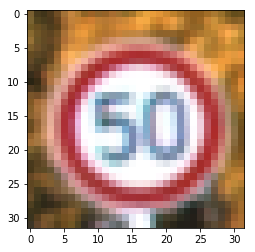

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import random
import csv

signnames = dict()
with open('signnames.csv', mode='r') as infile:
    reader = csv.DictReader(infile)
    for row in reader:
        class_id = row['ClassId']
        sign_name = row['SignName']
        signnames[class_id] = sign_name

def unnormalize_feature(feature):
    output = feature.copy()
    if output.dtype == np.float32:
        print("Restoring normalized feature")
        output = output * 128 + 128
        output = output.astype(np.uint8)
    return output

def display_sample_info(X_set, y_set):
    sample_idx = random.randint(0, y_set.size-1)
    sample_label_id = y_set[sample_idx]
    sample_label_name = signnames[str(sample_label_id)]
    maybe_normalized_sample_feature = X_set[sample_idx]
    sample_feature = unnormalize_feature(X_set[sample_idx])

    print("Displaying sample data from train set:")
    print(" - index in set: %d" % sample_idx)
    print(" - label id: %d" % sample_label_id)
    print(" - label name: %s" % sample_label_name)
    print(" - sample shape: ", sample_feature.shape)
    print(" - min pixel:", np.min(sample_feature))
    print(" - max pixel:", np.max(sample_feature))
    print(" - maybe normalized min pixel:", np.min(maybe_normalized_sample_feature))
    print(" - maybe normalized max pixel:", np.max(maybe_normalized_sample_feature))
    plt.imshow(sample_feature)

display_sample_info(X_train, y_train)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

In [4]:
# Normalize the data
def normalize_set(data):
    if data.dtype != np.float32:
        print("Applying Normalization over data set ...")
        data = data.astype(np.float32)
        data = (data - 128)/128
    else:
        print("set type is already {}.".format(data.dtype))
    return data

X_train = normalize_set(X_train)
X_valid = normalize_set(X_valid)
X_test = normalize_set(X_test)

Applying Normalization over data set ...
Applying Normalization over data set ...
Applying Normalization over data set ...


### Model Architecture

In [5]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 20
BATCH_SIZE = 128

def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # =======================
    # Layer 1
    # =======================
    # Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    # Activation.
    conv1 = tf.nn.relu(conv1)
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # =======================
    # Layer 2
    # =======================
    # Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    # Activation.
    conv2 = tf.nn.relu(conv2)
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # =======================
    # Layer 3
    # =======================
    # Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    # Activation.
    fc1 = tf.nn.relu(fc1)
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # =======================
    # Layer 4
    # =======================
    # Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    # Activation.
    fc2 = tf.nn.relu(fc2)
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # =======================
    # Layer 5
    # =======================
    # Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Features and Labels

In [6]:
# x is a placeholder for a batch of input images.
# y is a placeholder for a batch of output labels.
# Batch size is initialized to None, so it can receive a batch size of any size.
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))

# probability to keep units during dropout
keep_prob = tf.placeholder(tf.float32) 

# one hot encoded ground truth
one_hot_y = tf.one_hot(y, 43)

### Training Pipeline

The training pipeline is encoded in the `training_operation` variable.

In [7]:
rate = 0.001

# Pipeline:
# 1. Run LeNet on the input data.
# 2. Compare Logits to the ground truth labels and calculate the cross-entropy.
# 3. Keep averaged cross-entropy over all training images.
# 4. Use Adam Optimizer instead og S.G.D.
# 5. Run the uptimizer which uses back-propagation.
logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Model Evaluation
A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [8]:
# 1. Compare logit to the one hot encoding of ground truth labels.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))

# 2. Calculate pipeline accuracy by averaging individual prediction accuracies.
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 3. Average the Accuracy of each batch to compute the total accuracy of the model
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train the Model

* The data is shuffled before each epoch.
* Loss and Accuracy are measured on the validation set
* Model is saved after training


In [9]:
from sklearn.utils import shuffle
import time
from datetime import timedelta

def display_elapsed(start_time):
    elapsed = time.time() - start_time
    elapsed_str = str(timedelta(seconds=elapsed)).split(".")[0]
    print("Elapsed: {}".format(elapsed_str))

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    start_time = time.time()    
    for i in range(EPOCHS):
        epoch_start_time = time.time()
        
        # shuffle to eliminate bias on image order
        X_train, y_train = shuffle(X_train, y_train)
        
        # train each batch
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        # evaluate model on validation data
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        display_elapsed(epoch_start_time)
        print()    
    
    display_elapsed(start_time)
    saver.save(sess, './lenet')
    print("Model saved")

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


Training...

EPOCH 1 ...
Validation Accuracy = 0.573
Elapsed: 0:00:42

EPOCH 2 ...
Validation Accuracy = 0.788
Elapsed: 0:00:36

EPOCH 3 ...
Validation Accuracy = 0.862
Elapsed: 0:00:35

EPOCH 4 ...
Validation Accuracy = 0.884
Elapsed: 0:00:35

EPOCH 5 ...
Validation Accuracy = 0.885
Elapsed: 0:00:35

EPOCH 6 ...
Validation Accuracy = 0.923
Elapsed: 0:00:35

EPOCH 7 ...
Validation Accuracy = 0.919
Elapsed: 0:00:35

EPOCH 8 ...
Validation Accuracy = 0.925
Elapsed: 0:00:35

EPOCH 9 ...
Validation Accuracy = 0.933
Elapsed: 0:00:35

EPOCH 10 ...
Validation Accuracy = 0.937
Elapsed: 0:00:35

EPOCH 11 ...
Validation Accuracy = 0.941
Elapsed: 0:00:35

EPOCH 12 ...
Validation Accuracy = 0.941
Elapsed: 0:00:35

EPOCH 13 ...
Validation Accuracy = 0.940
Elapsed: 0:00:35

EPOCH 14 ...
Validation Accuracy = 0.945
Elapsed: 0:00:35

EPOCH 15 ...
Validation Accuracy = 0.946
Elapsed: 0:00:35

EPOCH 16 ...
Validation Accuracy = 0.944
Elapsed: 0:00:35

EPOCH 17 ...
Validation Accuracy = 0.946
Elapsed: 0:

### Model Evaluation on the Test Set

Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [10]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.938


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

Loading image: web_sample/sample_id12.png
Loading image: web_sample/sample_id14.png
Loading image: web_sample/sample_id17.png
Loading image: web_sample/sample_id18.png
Loading image: web_sample/sample_id25.png
Loading image: web_sample/sample_id35.png
Loading image: web_sample/sample_id38.png
Loading image: web_sample/sample_id7.png
Loading image: web_sample/sample_id_11.png


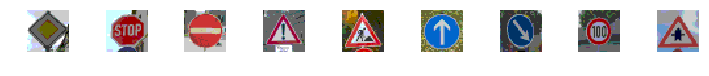

Applying Normalization over data set ...
Collected Data: (9, 32, 32, 3)
Restoring normalized feature
Displaying sample data from train set:
 - index in set: 5
 - label id: 35
 - label name: Ahead only
 - sample shape:  (32, 32, 3)
 - min pixel: 0
 - max pixel: 204
 - maybe normalized min pixel: -1.0
 - maybe normalized max pixel: 0.59375


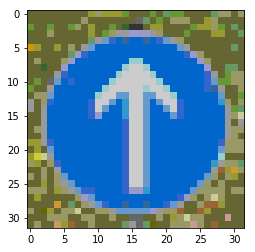

In [11]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob
import cv2
import re
import numpy as np
import matplotlib.pyplot as plt

images = glob.glob("web_sample/*.png")
X_web = []
y_web = []

def get_sample_id(fname):
    regex = re.compile(r'\d+')
    return int(regex.search(fname).group(0))

f, axs = plt.subplots(1, len(images), figsize=(10, 2))
f.tight_layout()
for idx, fname in enumerate(sorted(images)):
    print("Loading image: {}".format(fname))
    I = cv2.imread(fname)
    I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
    
    # save
    sample_id = get_sample_id(fname)
    X_web.append(I)
    y_web.append(sample_id)
    
    # display
    axs[idx].imshow(I)
    axs[idx].axis("off")
    
plt.show()

# as numpy
X_web = np.array(X_web)
y_web = np.array(y_web)

# preprocessing
X_web = normalize_set(X_web)

# display info
print("Collected Data: {}".format(X_web.shape))
display_sample_info(X_web, y_web)


### Predict the Sign Type for Each Image

In [12]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_web, y_web)
    print("Web Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Web Test Accuracy = 1.000


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [13]:
np.set_printoptions(precision=1)
np.set_printoptions(suppress=True)

check_top_5_operation = tf.nn.top_k(logits, k=5)

def check_web_results(X_data, y_data):
    sess = tf.get_default_session()
    return sess.run(check_top_5_operation, feed_dict={x: X_data, y: y_data, keep_prob: 1.0})    

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))   
    results = check_web_results(X_web, y_web)
    print(results)

INFO:tensorflow:Restoring parameters from ./lenet
TopKV2(values=array([[ 34. ,   1.9,  -0.6,  -1. ,  -2.1],
       [ 31.6,   6.8,   2.3,  -5. ,  -5.2],
       [ 23.8,   5.2,  -1.2,  -1.3,  -1.4],
       [ 57.1,  32.9,  11.2,   6.7,   5.1],
       [ 38.9,   8.9,   7.1,   5.8,   1.8],
       [ 49. ,  15.2,  12.7,   0.8,  -4.3],
       [ 58.2,  29.4,  11.6,  -4.8,  -6.2],
       [ 23.2,  14.8,  13.8,   3.8,  -2.3],
       [ 38. ,  23. ,  14.9,  11.3,   3.9]], dtype=float32), indices=array([[12, 10, 26, 17, 11],
       [14, 29, 17, 15,  1],
       [17, 14, 26, 10, 12],
       [18, 26, 27,  4, 22],
       [25, 29, 22, 24, 20],
       [35, 33, 34, 12,  3],
       [38, 34, 36, 25, 32],
       [ 7,  5,  8,  1, 31],
       [11, 30, 28, 21, 27]], dtype=int32))


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")